# Sheet02 Solution

Group members - 
1. Aayush Manoj Tirmalle (Matrikel nummer - 4730148)
2. Joshua Ulrich Mulihigoa Mauligalo (Matrikel nummer - 4269797)


###  1. Uniform Manifold Approximation and Projection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.sparse import lil_matrix, find
import sys

In [ ]:
# --- Configuration ---
# UMAP Hyperparameters from the exercise sheet
K_NEIGHBORS = 15
REPULSION_STRENGTH = 10.0
# Gradient Descent Parameters
N_EPOCHS = 200
INITIAL_LEARNING_RATE = 1.0
# Data Parameters (using all samples, as the dataset is reasonably sized)
# set N_SAMPLES_TO_USE (e.g., 5000) for faster testing.
N_SAMPLES_TO_USE = None

In [3]:
def load_local_jet_data():
    """
    Loads the jet physics dataset from local .npy files as specified in Sheet 1.
    It expects the files to be in a 'data/' subdirectory.
    """
    features_path = '../sheet01/data/dijet_features.npy'
    labels_path = '../sheet01/data/dijet_labels.npy'

    try:
        print(f"Loading features from '{features_path}'...")
        features = np.load(features_path)
        print(f"Loading labels from '{labels_path}'...")
        labels = np.load(labels_path)
    except FileNotFoundError as e:
        print(f"\n--- ERROR: Data file not found! ---\n")
        print(f"Could not find file: {e.filename}")
        print("Please make sure you have a 'data' folder with 'dijet_features.npy'")
        print("and 'dijet_labels.npy' in the same directory as this script.")
        print("See the required file structure in the solution guide.")
        sys.exit(1) # Exit the script cleanly

    # The data from Sheet 1 is shaped (features, samples), or (p, N).
    # Most scikit-learn tools expect (samples, features), or (N, p).
    # We must transpose the features matrix.
    data = features.T
    
    if N_SAMPLES_TO_USE is not None:
        print(f"Using a subset of {N_SAMPLES_TO_USE} samples for faster execution.")
        data = data[:N_SAMPLES_TO_USE, :]
        labels = labels[:N_SAMPLES_TO_USE]

    # As per Sheet 1, Exercise 1b, the data must be normalized.
    # We perform standard scaling (zero mean, unit variance).
    print("Normalizing data (zero mean, unit variance)...")
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    
    print(f"Data loaded and scaled. Shape: {data_scaled.shape}")
    return data_scaled, labels

In [4]:
# --- Step 2: Build Symmetrized kNN Graph & Extract Edges ---
def build_symmetrized_knn_graph(data, k):
    """
    Builds a k-Nearest Neighbors graph and symmetrizes it. An edge (i, j)
    exists if i is a neighbor of j OR j is a neighbor of i.
    """
    print(f"Building symmetrized kNN graph with k={k}...")
    n_points = data.shape[0]
    knn = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='euclidean')
    knn.fit(data)
    knn_indices = knn.kneighbors(data, return_distance=False)
    
    adj_matrix = lil_matrix((n_points, n_points))
    for i in range(n_points):
        adj_matrix[i, knn_indices[i, 1:]] = 1 # Skip first neighbor (self)
        
    symmetrized_adj = (adj_matrix + adj_matrix.T).astype(bool).tocoo()
    rows, cols, _ = find(symmetrized_adj)
    edges = set((i, j) for i, j in zip(rows, cols) if i < j)
            
    print(f"Graph built. Found {len(edges)} unique edges.")
    return edges

In [5]:
# --- Step 3: Do Force-Directed Layout using Gradient Descent ---
def force_directed_layout(data, edges, n_epochs, initial_lr, c):
    """
    Performs the force-directed layout optimization using gradient descent.
    The analytical derivatives are hard-coded as requested.
    """
    print("Starting force-directed layout...")
    n_points = data.shape[0]
    z = np.random.normal(size=(n_points, 2), scale=0.01)
    
    for epoch in range(n_epochs):
        learning_rate = initial_lr * (1.0 - (epoch / n_epochs))
        grad = np.zeros_like(z)
        
        # --- Attractive Force Calculation ---
        # Φ_attr(d^2) = log(1 + d^2)
        # ∇_zi Φ_attr = (2 * (z_i - z_j)) / (1 + ||z_i - z_j||^2)
        for i, j in edges:
            diff = z[i] - z[j]
            dist_sq = np.sum(diff**2)
            grad_vec = (2 * diff) / (1.0 + dist_sq + 1e-6)
            grad[i] += grad_vec
            grad[j] -= grad_vec
            
        # --- Repulsive Force Calculation ---
        # Φ_rep(d^2) = c / (1 + d^2)
        # ∇_zi Φ_rep = -2c * (z_i - z_j) / ((1 + ||z_i - z_j||^2)^2)
        n_repulsive_samples = 5 * n_points
        repulsive_i = np.random.randint(0, n_points, n_repulsive_samples)
        repulsive_j = np.random.randint(0, n_points, n_repulsive_samples)
        
        for i, j in zip(repulsive_i, repulsive_j):
            if i == j: continue
            diff = z[i] - z[j]
            dist_sq = np.sum(diff**2)
            grad_vec = (-2 * c * diff) / ((1.0 + dist_sq + 1e-6)**2)
            grad[i] += grad_vec
            grad[j] -= grad_vec

        z -= learning_rate * grad
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, LR: {learning_rate:.4f}")
            
    print("Layout optimization complete.")
    return z

In [6]:
# --- Main UMAP execution wrapper ---
def simplified_umap(data, k, n_epochs, initial_lr, c):
    edges = build_symmetrized_knn_graph(data, k)
    embedding = force_directed_layout(data, edges, n_epochs, initial_lr, c)
    return embedding

Loading features from '../sheet01/data/dijet_features.npy'...
Loading labels from '../sheet01/data/dijet_labels.npy'...
Normalizing data (zero mean, unit variance)...
Data loaded and scaled. Shape: (2233, 116)

--- Running Simplified UMAP ---
Building symmetrized kNN graph with k=15...
Graph built. Found 24595 unique edges.
Starting force-directed layout...
Epoch 20/200, LR: 0.9050
Epoch 40/200, LR: 0.8050
Epoch 60/200, LR: 0.7050
Epoch 80/200, LR: 0.6050
Epoch 100/200, LR: 0.5050
Epoch 120/200, LR: 0.4050
Epoch 140/200, LR: 0.3050
Epoch 160/200, LR: 0.2050
Epoch 180/200, LR: 0.1050
Epoch 200/200, LR: 0.0050
Layout optimization complete.

--- Running PCA ---


C:\Users\User\AppData\Local\Temp\ipykernel_21392\975272033.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.96])


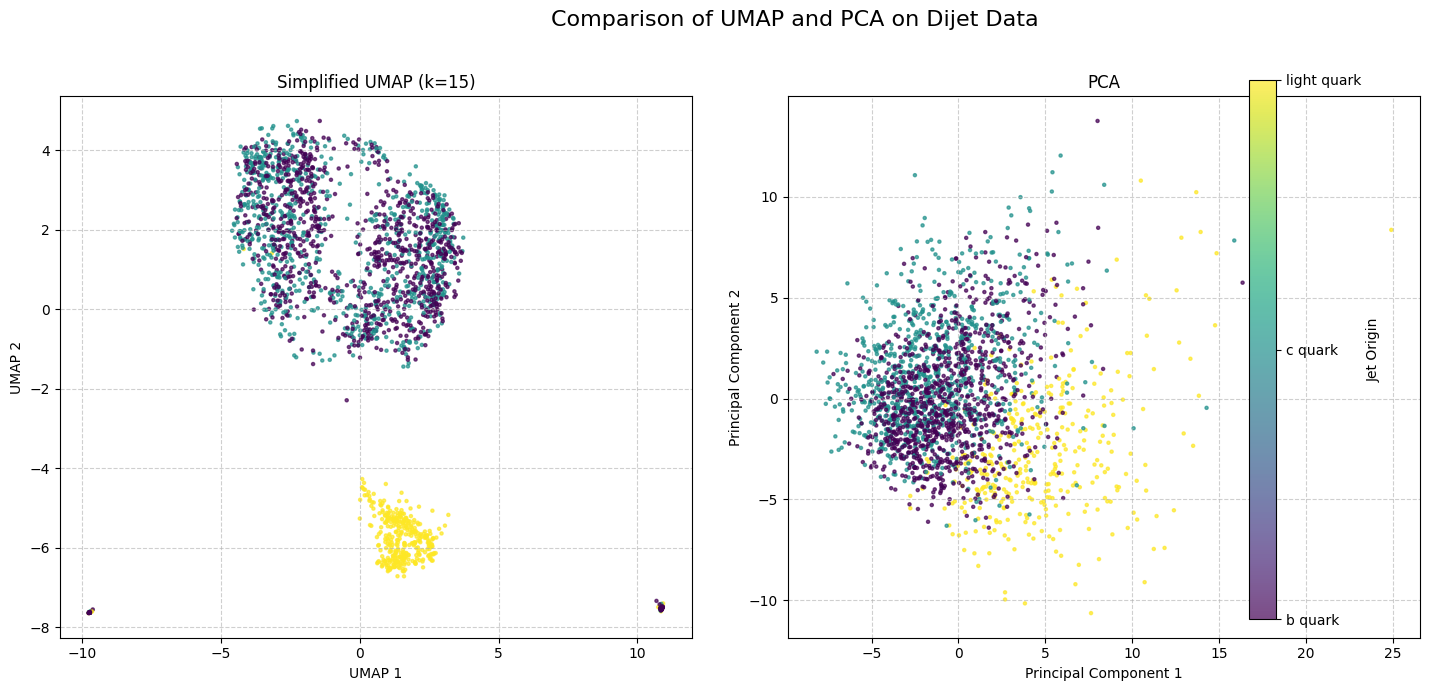


--- Interpretation of Results ---
The plots compare 2D embeddings of the high-dimensional dijet data from our simplified UMAP and standard PCA.

PCA (Principal Component Analysis):
 - PCA projects the data onto the two linear axes of highest variance. The resulting plot shows a single, dense cloud of points.
 - The three classes (b, c, and light quarks) are heavily mixed and almost impossible to distinguish. This means the global variance is not aligned with the class boundaries.

Simplified UMAP (Uniform Manifold Approximation and Projection):
 - UMAP is a non-linear method that preserves local neighborhood structures. The embedding it creates is significantly more structured.
 - We can see a clear separation between the different jet types. The classes form distinct clusters, although there might be some overlap between the 'c' and 'light' quarks, which are physically more similar.
 - This result highlights UMAP's power in finding and visualizing the underlying non-linear manifold o

In [7]:
# =============================================================================
# (b) Apply UMAP to the jet data and compare with PCA.
# =============================================================================
def main():
    """
    Main execution block: Loads data, runs UMAP and PCA, and plots results.
    """
    data, labels = load_local_jet_data()
        
    print("\n--- Running Simplified UMAP ---")
    umap_embedding = simplified_umap(
        data=data, k=K_NEIGHBORS, n_epochs=N_EPOCHS,
        initial_lr=INITIAL_LEARNING_RATE, c=REPULSION_STRENGTH
    )
    
    print("\n--- Running PCA ---")
    pca = PCA(n_components=2)
    pca_embedding = pca.fit_transform(data)
    
    # --- Visualization and Comparison ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    label_names = ['b quark', 'c quark', 'light quark']
    
    # Plot UMAP
    scatter1 = ax1.scatter(
        umap_embedding[:, 0], umap_embedding[:, 1],
        c=labels, cmap='viridis', s=5, alpha=0.7
    )
    ax1.set_title(f'Simplified UMAP (k={K_NEIGHBORS})')
    ax1.set_xlabel('UMAP 1')
    ax1.set_ylabel('UMAP 2')
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    # Plot PCA
    scatter2 = ax2.scatter(
        pca_embedding[:, 0], pca_embedding[:, 1],
        c=labels, cmap='viridis', s=5, alpha=0.7
    )
    ax2.set_title('PCA')
    ax2.set_xlabel('Principal Component 1')
    ax2.set_ylabel('Principal Component 2')
    ax2.grid(True, linestyle='--', alpha=0.6)
    
    # Add a shared colorbar with class names
    cbar = fig.colorbar(scatter1, ax=[ax1, ax2], ticks=[0, 1, 2])
    cbar.ax.set_yticklabels(label_names)
    cbar.set_label('Jet Origin')

    fig.suptitle('Comparison of UMAP and PCA on Dijet Data', fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.9, 0.96])
    plt.show()

    # --- Interpretation ---
    print("\n--- Interpretation of Results ---")
    print("The plots compare 2D embeddings of the high-dimensional dijet data from our simplified UMAP and standard PCA.")
    print("\nPCA (Principal Component Analysis):")
    print(" - PCA projects the data onto the two linear axes of highest variance. The resulting plot shows a single, dense cloud of points.")
    print(" - The three classes (b, c, and light quarks) are heavily mixed and almost impossible to distinguish. This means the global variance is not aligned with the class boundaries.")
    print("\nSimplified UMAP (Uniform Manifold Approximation and Projection):")
    print(" - UMAP is a non-linear method that preserves local neighborhood structures. The embedding it creates is significantly more structured.")
    print(" - We can see a clear separation between the different jet types. The classes form distinct clusters, although there might be some overlap between the 'c' and 'light' quarks, which are physically more similar.")
    print(" - This result highlights UMAP's power in finding and visualizing the underlying non-linear manifold of the data, making it a superior tool for exploratory analysis of this dataset compared to PCA.")


if __name__ == '__main__':
    main()

###  2. Kernel Density Estimation


#### (a) Effect of Bandwidth on KDE

The density estimate using an RBF kernel is:

$$
k(x) = \frac{1}{w\sqrt{2\pi}} \sum_{n=1}^N \exp\left(-\frac{(x - x_n)^2}{2w^2}\right)
$$

- **Very small bandwidth ($w \ll 1$):** Each kernel is very narrow, so the density estimate will show sharp peaks at each data point and be nearly zero elsewhere. The result is a spiky, overfit density.
- **Very large bandwidth ($w \gg 1$):** Each kernel is very wide, so the density estimate will be very smooth and may miss important features of the data, possibly resembling a broad Gaussian.
- **Recommended bandwidth for this dataset:** Typically, a value close to the average distance between neighboring points works well. For the provided data, a reasonable choice is the standard deviation of the data divided by $\sqrt{N}$, or use cross-validation to select $w$.

Bandwidth 0.05: kde shape = (500,), x_grid shape = (500,)
Bandwidth 0.2: kde shape = (500,), x_grid shape = (500,)
Bandwidth 1.0: kde shape = (500,), x_grid shape = (500,)


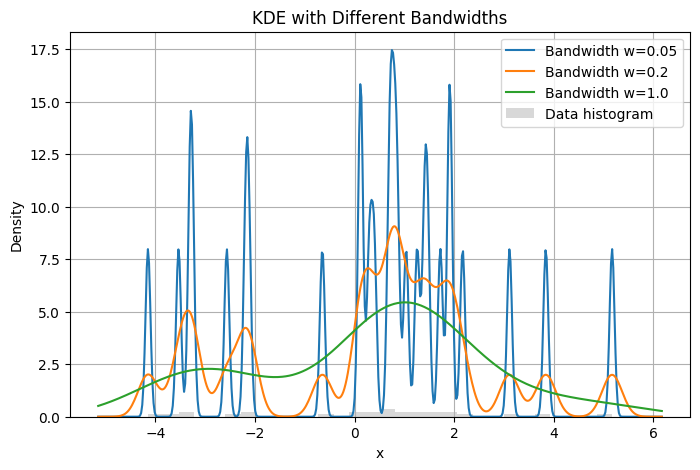

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Load 1D data
data = np.load('data/kde_1d_data.npy')
N = data.shape[0]
x_grid = np.linspace(data.min()-1, data.max()+1, 500)

# KDE function
def kde_rbf(x_grid, data, w):
    x_grid = np.asarray(x_grid).reshape(-1)
    data = np.asarray(data).reshape(-1)
    result = np.sum(np.exp(-(x_grid[:,None] - data[None,:])**2 / (2*w**2)), axis=1) / (N * w * np.sqrt(2*np.pi))
    return result

bandwidths = [0.05, 0.2, 1.0]
plt.figure(figsize=(8,5))
for w in bandwidths:
    kde = kde_rbf(x_grid, data, w)
    print(f"Bandwidth {w}: kde shape = {kde.shape}, x_grid shape = {x_grid.shape}")
    plt.plot(x_grid, kde, label=f'Bandwidth w={w}')
plt.hist(data.flatten(), bins=30, density=True, alpha=0.3, color='gray', label='Data histogram')
plt.title('KDE with Different Bandwidths')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

#### (b) Scheme to Adjust Bandwidth Locally

A common approach is to use **adaptive bandwidth**:
- For each data point $x_n$, set its bandwidth $w_n$ proportional to the local density (e.g., the distance to its $k$-th nearest neighbor).
- Pseudocode:

```python
for each data point x_n:
    w_n = distance to k-th nearest neighbor of x_n
```
- This makes the kernel wider in sparse regions and narrower in dense regions, improving the KDE estimate.

#### (c) Bonus: KDE with Fast Fourier Transform (FFT)

**Description:**
- For large 1D datasets, KDE can be computed efficiently by convolving the data histogram with the kernel using FFT.
- Steps:
    1. Bin the data into a histogram.
    2. Compute the kernel values on the same grid.
    3. Use FFT to convolve the histogram and kernel.

**Pseudocode:**
```python
hist = histogram(data, bins)
kernel = gaussian_kernel(grid, bandwidth)
kde = fft_convolve(hist, kernel)
```

**High-dimensional data:**
- FFT-based KDE does **not** scale well to high dimensions because the grid size grows exponentially (curse of dimensionality).
- For high-dimensional data, direct evaluation or tree-based methods are preferred.

### 3. Linear Regression: $\sigma^2$ Estimation and Heteroscedastic Noise

#### (a) Maximum Likelihood Estimation for $\beta$ and $\sigma^2$

Given the linear regression model:
$$
y_n = \beta^T x_n + \epsilon_n
$$
where $\epsilon_n \sim \mathcal{N}(0, \sigma^2)$, the likelihood for $N$ data points is:
$$
p(y_n | \beta, \sigma^2) = \mathcal{N}(y_n | \beta^T x_n, \sigma^2)
$$

##### Step 1: Estimate $\beta$ by maximizing the log-likelihood
$$
\hat{\beta} = \arg\max_{\beta} \sum_{n=1}^N \log \mathcal{N}(y_n | \beta^T x_n, \sigma^2)
$$
This is equivalent to minimizing the sum of squared residuals (SSQ):
$$
\hat{\beta} = \arg\min_{\beta} \sum_{n=1}^N (y_n - \beta^T x_n)^2
$$

##### Step 2: Estimate $\sigma^2$ by maximizing the log-likelihood given $\hat{\beta}$
$$
\hat{\sigma}^2 = \arg\max_{\sigma^2} \sum_{n=1}^N \log \mathcal{N}(y_n | \hat{\beta}^T x_n, \sigma^2)
$$
This leads to:
$$
\hat{\sigma}^2 = \frac{1}{N} \sum_{n=1}^N (y_n - \hat{\beta}^T x_n)^2
$$

**Relation to SSQ:**
- The maximum likelihood estimate of $\sigma^2$ is the mean of the squared residuals (the SSQ divided by $N$).
- This matches the result from the lecture: the variance estimate is the average squared error after fitting $\beta$.


#### (b) Heteroscedastic Noise: Weighted Least Squares and Mean Structure of $\hat{\beta}$

**Question Recap:**
- In standard linear regression, the noise variance is constant (homoscedastic).
- In the heteroscedastic case, each data point $n$ has its own variance $\sigma_n^2$:
  $$
  y_n = \beta^T x_n + \epsilon_n, \quad \mathbb{E}[\epsilon_n] = 0, \quad \mathrm{Var}[\epsilon_n] = \sigma_n^2
  $$

##### Sum-of-Squares Problem (Weighted Least Squares)
- The log-likelihood for $N$ data points is:
  $$
  \sum_{n=1}^N \log \mathcal{N}(y_n | \beta^T x_n, \sigma_n^2)
  $$
- Maximizing this is equivalent to minimizing the **weighted sum of squares**:
  $$
  \hat{\beta} = \arg\min_{\beta} \sum_{n=1}^N \frac{1}{\sigma_n^2} (y_n - \beta^T x_n)^2
  $$
- This is called **weighted least squares (WLS)**.

##### Mean Structure of $\hat{\beta}$
- The solution for $\hat{\beta}$ is:
  $$
  \hat{\beta} = \left( X^T W X \right)^{-1} X^T W y
  $$
  where:
    - $X$ is the design matrix (rows $x_n^T$)
    - $y$ is the vector of targets
    - $W$ is a diagonal matrix with entries $W_{nn} = 1/\sigma_n^2$
- The mean structure:
  $$
  \mathbb{E}[\hat{\beta}] = \beta
  $$
  (assuming the model is correctly specified and $\epsilon_n$ are zero-mean)

**Summary:**
- For heteroscedastic noise, use weighted least squares, weighting each residual by $1/\sigma_n^2$.
- The mean of $\hat{\beta}$ is still $\beta$ if the model assumptions hold.
